In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
sys.path.append("..")
from src import *

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
blue = sns.color_palette("colorblind")[0]
pink = sns.color_palette("colorblind")[4] 

In [17]:
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"

In [18]:
data = get_data_csv(high_quality_only=False, pfs=True, config_path=os.path.join(base, "je30bery/archive/melanoma_data/config.json"))
data = data.reset_index().drop("index", axis=1)

data["Sex"].replace({"m": 1., "f": 0.}, inplace=True)
data["Ulcerated"].replace({True: 1., False: 0.}, inplace=True)

In [19]:
np.unique(data["PFS < 5"], return_counts=True)

(array([0., 1.]), array([97, 15]))

In [20]:
pfs0_pats = data[data["PFS < 5"] == 0]["Patient ID"]
pfs1_pats = data[data["PFS < 5"] == 0]["Patient ID"]
palette = {pat: blue for pat in pfs0_pats}.update({pat: pink for pat in pfs1_pats})

In [21]:
def plot_samples_distri(ax):
    pos = np.unique(data[data["PFS < 5"] == 1]["Patient ID"])
    neg = np.unique(data[data["PFS < 5"] == 0]["Patient ID"])
    palette = {pat: pink for i, pat in enumerate(pos)}
    palette.update({pat: blue for i, pat in enumerate(neg)})
    
    sns.histplot(data, x="PFS < 5", hue="Patient ID", multiple="stack", bins=2, legend=False, palette=palette, ax=ax)
    ax.set_xticks(ticks=[0.25,0.75], labels=["PFS ≥ 5", "PFS < 5"])
    #ax.set_title("Samples colored by patient ID")
    #plt.savefig("data_overview.png")
    return ax

In [22]:
def plot_thickness(ax):
    palette = {"PFS ≥ 5": blue, 
               "PFS < 5": pink}
    sns.histplot(data.replace({0: "PFS ≥ 5", 1: "PFS < 5"}), x="Tumor Thickness [mm]", hue="PFS < 5", palette=palette, multiple="layer", ax=ax)
    #plt.savefig("thickness_by_label.png")
    return ax

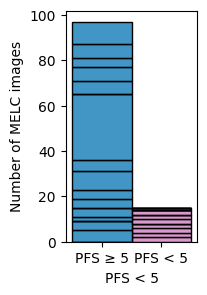

In [23]:
f, ax = plt.subplots(1, figsize=(1.7, 3))
ax = plot_samples_distri(ax)
ax.set_ylabel("Number of MELC images")
plt.savefig("../result_plots/sample_distri.svg", bbox_inches="tight")

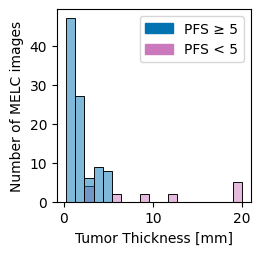

In [24]:
f, ax = plt.subplots(1, figsize=(2.5, 2.5))
ax = plot_thickness(ax)

palette = {"PFS ≥ 5": blue, "PFS < 5": pink}
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
plt.legend(handles=legend_handles, frameon=True)

ax.set_ylabel("Number of MELC images")
plt.savefig("../result_plots/tumor_thickness_distri.svg", bbox_inches="tight")